In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#from torch.autograd import Variable

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from math import sqrt

In [2]:
df = pd.read_csv('ISEMData.csv')

In [3]:
df.head()

,DeliveryPeriod,EURPrices,WF,DF
0,11/11/2018 23:00,55.089,2695.41,3845.0
1,12/11/2018 00:00,55.120,2704.95,3501.0
2,12/11/2018 01:00,46.460,2694.56,3341.0
3,12/11/2018 02:00,45.710,2697.30,3226.0
4,12/11/2018 03:00,41.380,2649.02,3157.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30696 entries, 0 to 30695
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DeliveryPeriod  30696 non-null  object 
 1   EURPrices       30696 non-null  float64
 2   WF              30696 non-null  float64
 3   DF              30696 non-null  float64
dtypes: float64(3), object(1)
memory usage: 959.4+ KB


In [5]:
df['DeliveryPeriod'] = pd.to_datetime(df['DeliveryPeriod'], format='%d/%m/%Y %H:%M')

In [6]:
df['date'] = df['DeliveryPeriod'].dt.strftime("%d-%m-%Y")
df['time'] = df['DeliveryPeriod'].dt.strftime("%H:%M:%S")


In [7]:
y = df.EURPrices  # response
X1= df.WF  # predictor 1
X2= df.DF #predictor 2
X1=sm.add_constant(X1)
X2 = sm.add_constant(X2)  # Adds a constant term to the predictor


In [8]:
X1.head()

,const,WF
0,1.0,2695.41
1,1.0,2704.95
2,1.0,2694.56
3,1.0,2697.30
4,1.0,2649.02


In [9]:
X2.head()

,const,DF
0,1.0,3845.0
1,1.0,3501.0
2,1.0,3341.0
3,1.0,3226.0
4,1.0,3157.0


**Now we perform the regression of the predictor on the response, using the sm.OLS class and and its initialization OLS(y, X) method. This method takes as an input two array-like objects: X and y. In general, X will either be a numpy array or a pandas data frame with shape (n, p) where n is the number of data points and p is the number of predictors. y is either a one-dimensional numpy array or a pandas series of length n.**

In [10]:
est1 = sm.OLS(y, X1) #wind forecast

**We then need to fit the model by calling the OLS object's fit() method. Ignore the warning about the kurtosis test if it appears, we have only 16 examples in our dataset and the test of the kurtosis is valid only if there are more than 20 examples**

In [11]:
est1 = est1.fit()
est1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              EURPrices   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     879.3
Date:                Mon, 12 Sep 2022   Prob (F-statistic):          1.54e-190
Time:                        22:11:20   Log-Likelihood:            -1.7797e+05
No. Observations:               30696   AIC:                         3.559e+05
Df Residuals:                   30694   BIC:                         3.560e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.0298      0.756    141.621      0.000     105.548     108.511
WF            -0.0114      0.000    -29.652      0.000      -0.012      -0.011
==============================================================================
Omnibus:                    10757.186   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34413.232
Skew:                           1.826   Prob(JB):                         0.00
Kurtosis:                       6.685   Cond. No.                     3.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
est1.params

const    107.029791
WF        -0.011389
dtype: float64

Populating the interactive namespace from numpy and matplotlib


C:\Users\user\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


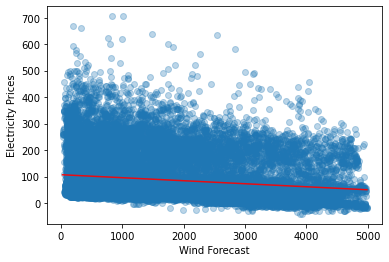

In [13]:
%pylab inline

# We pick 500 hundred points equally spaced from the min to the max
X1_prime = np.linspace(X1.WF.min(), X1.WF.max(), 500)[:, np.newaxis]
X1_prime = sm.add_constant(X1_prime)  # add constant as we did before

# Now we calculate the predicted values
y_hat = est1.predict(X1_prime)

plt.scatter(X1.WF, y, alpha=0.3)  # Plot the raw data
plt.xlabel("Wind Forecast")
plt.ylabel("Electricity Prices")
plt.plot(X1_prime[:, 1], y_hat, 'r', alpha=0.9)  # Add the regression line, colored in red

In [14]:
import statsmodels.formula.api as smf

# formula: response ~ predictors
est1= smf.ols(formula='EURPrices ~ WF', data=df).fit()
est1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              EURPrices   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     879.3
Date:                Mon, 12 Sep 2022   Prob (F-statistic):          1.54e-190
Time:                        22:11:21   Log-Likelihood:            -1.7797e+05
No. Observations:               30696   AIC:                         3.559e+05
Df Residuals:                   30694   BIC:                         3.560e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    107.0298      0.756    141.621      0.000     105.548     108.511
WF            -0.0114      0.000    -29.652      0.000      -0.012      -0.011
==============================================================================
Omnibus:                    10757.186   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34413.232
Skew:                           1.826   Prob(JB):                         0.00
Kurtosis:                       6.685   Cond. No.                     3.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

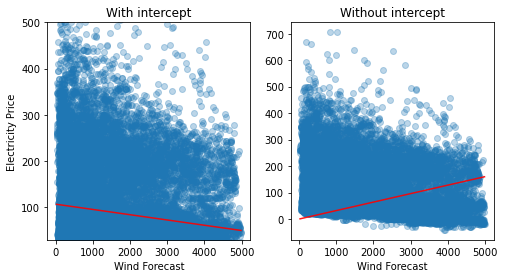

In [15]:
# Fit the no-intercept model
est1_no_int = smf.ols(formula='EURPrices ~ WF - 1', data=df).fit()

# We pick 100 hundred points equally spaced from the min to the max
X1_prime_1 = pd.DataFrame({'WF': np.linspace(X1.WF.min(), X1.WF.max(), 500)})
X1_prime_1 = sm.add_constant(X1_prime_1)  # add constant as we did before

y_hat_int = est1.predict(X1_prime_1)
y_hat_no_int = est1_no_int.predict(X1_prime_1)

fig = plt.figure(figsize=(8,4))
splt = plt.subplot(121)

splt.scatter(X1.WF, y, alpha=0.3)  # Plot the raw data
plt.ylim(30, 500)  # Set the y-axis to be the same
plt.xlabel("Wind Forecast")
plt.ylabel("Electricity Price")
plt.title("With intercept")
splt.plot(X1_prime[:, 1], y_hat_int, 'r', alpha=0.9)  # Add the regression line, colored in red

splt = plt.subplot(122)
splt.scatter(X1.WF, y, alpha=0.3)  # Plot the raw data
plt.xlabel("Wind Forecast")
plt.title("Without intercept")
splt.plot(X1_prime[:, 1], y_hat_no_int, 'r', alpha=0.9)  # Add the regression line, colored in red

# Demand

In [16]:
est2 = sm.OLS(y, X2)

In [17]:
est2 = est2.fit() #demand forecast
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              EURPrices   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     5126.
Date:                Mon, 12 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:11:21   Log-Likelihood:            -1.7603e+05
No. Observations:               30696   AIC:                         3.521e+05
Df Residuals:                   30694   BIC:                         3.521e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -64.2996      2.185    -29.423      0.000     -68.583     -60.016
DF             0.0352      0.000     71.595      0.000       0.034       0.036
==============================================================================
Omnibus:                     9285.227   Durbin-Watson:                   0.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26119.439
Skew:                           1.613   Prob(JB):                         0.00
Kurtosis:                       6.164   Cond. No.                     2.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
est2.params

const   -64.299632
DF        0.035203
dtype: float64

Populating the interactive namespace from numpy and matplotlib


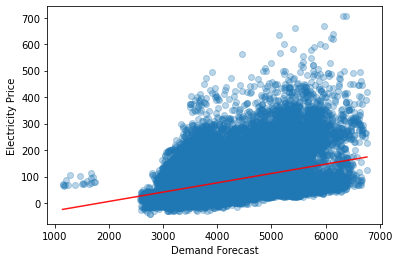

In [19]:
%pylab inline

# We pick 500 hundred points equally spaced from the min to the max
X2_prime = np.linspace(X2.DF.min(), X2.DF.max(), 500)[:, np.newaxis]
X2_prime = sm.add_constant(X2_prime)  # add constant as we did before

# Now we calculate the predicted values
y_hat = est2.predict(X2_prime)

plt.scatter(X2.DF, y, alpha=0.3)  # Plot the raw data
plt.xlabel("Demand Forecast")
plt.ylabel("Electricity Price")
plt.plot(X2_prime[:, 1], y_hat, 'r', alpha=0.9)  # Add the regression line, colored in red

**Statsmodels also provides a formulaic interface that will be familiar to users of R. Note that this requires the use of a different api to statsmodels, and the class is now called ols rather than OLS. The argument formula allows you to specify the response and the predictors using the column names of the input data frame data.**

In [20]:
import statsmodels.formula.api as smf

# formula: response ~ predictors
est2 = smf.ols(formula='EURPrices ~ DF', data=df).fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              EURPrices   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     5126.
Date:                Mon, 12 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:11:21   Log-Likelihood:            -1.7603e+05
No. Observations:               30696   AIC:                         3.521e+05
Df Residuals:                   30694   BIC:                         3.521e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -64.2996      2.185    -29.423      0.000     -68.583     -60.016
DF             0.0352      0.000     71.595      0.000       0.034       0.036
==============================================================================
Omnibus:                     9285.227   Durbin-Watson:                   0.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26119.439
Skew:                           1.613   Prob(JB):                         0.00
Kurtosis:                       6.164   Cond. No.                     2.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

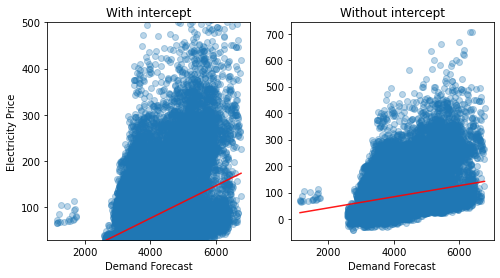

In [21]:
# Fit the no-intercept model
est2_no_int = smf.ols(formula='EURPrices ~ DF - 1', data=df).fit()

# We pick 100 hundred points equally spaced from the min to the max
X2_prime_1 = pd.DataFrame({'DF': np.linspace(X2.DF.min(), X2.DF.max(), 500)})
X2_prime_1 = sm.add_constant(X2_prime_1)  # add constant as we did before

y_hat_int = est2.predict(X2_prime_1)
y_hat_no_int = est2_no_int.predict(X2_prime_1)

fig = plt.figure(figsize=(8,4))
splt = plt.subplot(121)

splt.scatter(X2.DF, y, alpha=0.3)  # Plot the raw data
plt.ylim(30, 500)  # Set the y-axis to be the same
plt.xlabel("Demand Forecast")
plt.ylabel("Electricity Price")
plt.title("With intercept")
splt.plot(X2_prime[:, 1], y_hat_int, 'r', alpha=0.9)  # Add the regression line, colored in red

splt = plt.subplot(122)
splt.scatter(X2.DF, y, alpha=0.3)  # Plot the raw data
plt.xlabel("Demand Forecast")
plt.title("Without intercept")
splt.plot(X2_prime[:, 1], y_hat_no_int, 'r', alpha=0.9)  # Add the regression line, colored in red

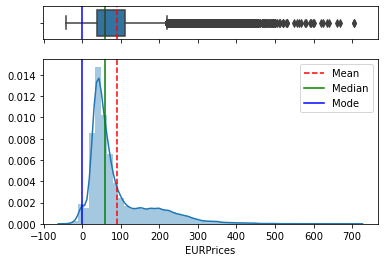

In [22]:
f, (ax_box, ax_dist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=df['EURPrices'].mean()
median=df['EURPrices'].median()
mode=df['EURPrices'].mode().values[0]

sns.boxplot(data=df, x="EURPrices", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.distplot(df['EURPrices'], ax=ax_dist, kde=True)
ax_dist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_dist.axvline(median, color='g', linestyle='-', label="Median")
ax_dist.axvline(mode, color='b', linestyle='-', label="Mode")

ax_dist.legend()

ax_box.set(xlabel='')
plt.show()

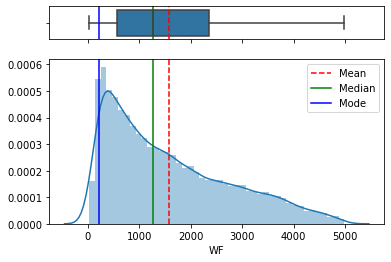

In [23]:
f, (ax_box, ax_dist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=df['WF'].mean()
median=df['WF'].median()
mode=df['WF'].mode().values[0]

sns.boxplot(data=df, x="WF", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.distplot(df['WF'], ax=ax_dist, kde=True)
ax_dist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_dist.axvline(median, color='g', linestyle='-', label="Median")
ax_dist.axvline(mode, color='b', linestyle='-', label="Mode")

ax_dist.legend()

ax_box.set(xlabel='')
plt.show()

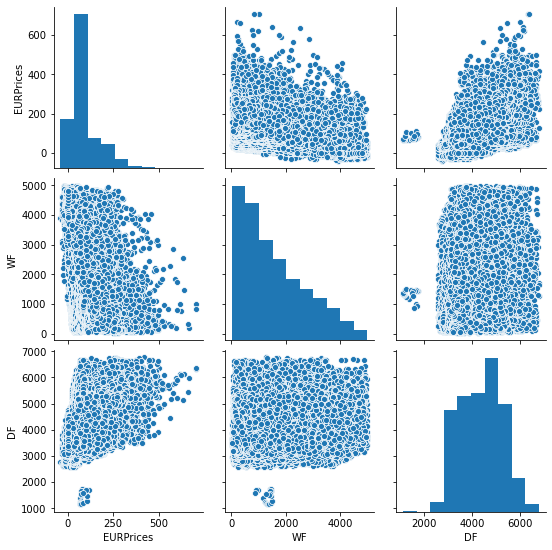

In [24]:
sns.pairplot(df)

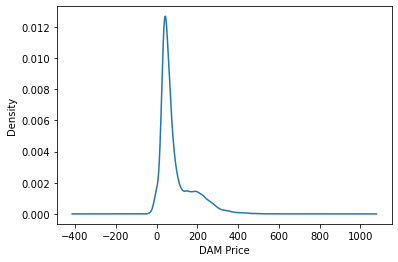

In [25]:
#Our dependent values(y) are price 
df.EURPrices.plot.density()
plt.xlabel('DAM Price', color='black')
plt.show()

In [26]:
log_price = np.log(df['EURPrices'])

# Then we add it to our data frame
df['log_price'] = log_price

C:\Users\user\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30696 entries, 0 to 30695
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DeliveryPeriod  30696 non-null  datetime64[ns]
 1   EURPrices       30696 non-null  float64       
 2   WF              30696 non-null  float64       
 3   DF              30696 non-null  float64       
 4   date            30696 non-null  object        
 5   time            30696 non-null  object        
 6   log_price       30071 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 1.6+ MB


# dropping infs and nans

In [28]:
df.dropna()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
#df[df.apply(np.isfinite).all(axis=1)]

In [29]:
df['EURPrices'].agg(['min', 'max'])

min    -41.09
max    705.47
Name: EURPrices, dtype: float64

Text(0.5, 0, 'Log DAM Price')

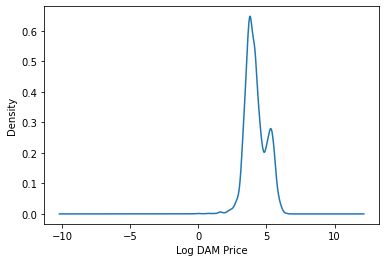

In [30]:
df['log_price'].plot.density()
plt.xlabel('Log DAM Price', color='black')

In [31]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['EURPrices'])
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Power):
    result=adfuller(Power)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(df['EURPrices'])

ADF Test Statistic : -4.712759259030066
p-value : 7.962905147372187e-05
#Lags Used : 48
Number of Observations Used : 30647
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [32]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['DF'])
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Power):
    result=adfuller(Power)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(df['DF'])

ADF Test Statistic : -11.53693565246433
p-value : 3.713754531797238e-21
#Lags Used : 51
Number of Observations Used : 30644
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [33]:
##Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['WF'])
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Power):
    result=adfuller(Power)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(df['WF'])

ADF Test Statistic : -14.185569564925924
p-value : 1.895534549729136e-26
#Lags Used : 50
Number of Observations Used : 30645
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


# Building model

In [34]:
df['DeliveryPeriod'] = pd.to_datetime(df['DeliveryPeriod'], format='%d/%m/%Y %H:%M')
df['date'] = df['DeliveryPeriod'].dt.strftime("%d-%m-%Y")
df['time'] = df['DeliveryPeriod'].dt.strftime("%H:%M:%S")

In [35]:
df['delivery_time'] = df['DeliveryPeriod'].dt.strftime("%H:%M:%S")

In [36]:
df.head(2)

,DeliveryPeriod,EURPrices,WF,DF,date,time,log_price,delivery_time
0,2018-11-11 23:00:00,55.089,2695.41,3845.0,11-11-2018,23:00:00,4.008950,23:00:00
1,2018-11-12 00:00:00,55.120,2704.95,3501.0,12-11-2018,00:00:00,4.009513,00:00:00


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30696 entries, 0 to 30695
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DeliveryPeriod  30696 non-null  datetime64[ns]
 1   EURPrices       30696 non-null  float64       
 2   WF              30696 non-null  float64       
 3   DF              30696 non-null  float64       
 4   date            30696 non-null  object        
 5   time            30696 non-null  object        
 6   log_price       29808 non-null  float64       
 7   delivery_time   30696 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 1.9+ MB


In [38]:
data_normal=df.drop(['EURPrices','DeliveryPeriod','date','time'],axis=1)
data_normal

,WF,DF,log_price,delivery_time
0,2695.410,3845.0,4.008950,23:00:00
1,2704.950,3501.0,4.009513,00:00:00
2,2694.560,3341.0,3.838592,01:00:00
3,2697.300,3226.0,3.822317,02:00:00
4,2649.020,3157.0,3.722798,03:00:00
...,...,...,...,...
30691,2328.527,5037.0,4.680185,18:00:00
30692,1964.987,4878.0,4.833659,19:00:00
30693,1691.419,4783.0,4.950531,20:00:00
30694,1386.061,4675.0,5.087596,21:00:00


In [39]:
data_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30696 entries, 0 to 30695
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   WF             30696 non-null  float64
 1   DF             30696 non-null  float64
 2   log_price      29808 non-null  float64
 3   delivery_time  30696 non-null  object 
dtypes: float64(3), object(1)
memory usage: 959.4+ KB


In [40]:
df_copy = df.copy(deep=True) # Make a deep copy, including a copy of the data and the indices

df_copy.set_index('date',inplace=True)

df_copy.index = pd.to_datetime(df_copy.index)
df_copy.head(5)

,DeliveryPeriod,EURPrices,WF,DF,time,log_price,delivery_time
date,,,,,,,
2018-11-11,2018-11-11 23:00:00,55.089,2695.41,3845.0,23:00:00,4.008950,23:00:00
2018-12-11,2018-11-12 00:00:00,55.120,2704.95,3501.0,00:00:00,4.009513,00:00:00
2018-12-11,2018-11-12 01:00:00,46.460,2694.56,3341.0,01:00:00,3.838592,01:00:00
2018-12-11,2018-11-12 02:00:00,45.710,2697.30,3226.0,02:00:00,3.822317,02:00:00
2018-12-11,2018-11-12 03:00:00,41.380,2649.02,3157.0,03:00:00,3.722798,03:00:00


In [41]:
df_logprice = df_copy[['log_price']]

In [42]:
df_price = df_copy[['EURPrices']]

In [43]:
prediction_window=12

In [44]:
n_input=12 #Use 12 months data to predict 13 th month data
n_features=1 # we are dealing with an univariate time series, so n_features should be set to 1. 
#In case of a multivariate time series, n_features should be set to a proper value higher than 1.

In [45]:
train = df_logprice.copy()

In [46]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

# checking for multicollinearity

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = df[['DF','WF','EURPrices']]

In [48]:
# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = variables.columns
vif

,VIF,Features
0,5.369515,DF
1,2.943222,WF
2,2.684092,EURPrices


In [49]:
df.head()

,DeliveryPeriod,EURPrices,WF,DF,date,time,log_price,delivery_time
0,2018-11-11 23:00:00,55.089,2695.41,3845.0,11-11-2018,23:00:00,4.008950,23:00:00
1,2018-11-12 00:00:00,55.120,2704.95,3501.0,12-11-2018,00:00:00,4.009513,00:00:00
2,2018-11-12 01:00:00,46.460,2694.56,3341.0,12-11-2018,01:00:00,3.838592,01:00:00
3,2018-11-12 02:00:00,45.710,2697.30,3226.0,12-11-2018,02:00:00,3.822317,02:00:00
4,2018-11-12 03:00:00,41.380,2649.02,3157.0,12-11-2018,03:00:00,3.722798,03:00:00


In [50]:
data_normal.head()

,WF,DF,log_price,delivery_time
0,2695.41,3845.0,4.008950,23:00:00
1,2704.95,3501.0,4.009513,00:00:00
2,2694.56,3341.0,3.838592,01:00:00
3,2697.30,3226.0,3.822317,02:00:00
4,2649.02,3157.0,3.722798,03:00:00


In [51]:
y = df['log_price']
#x = df.drop(['EURPrices','year','month','DeliveryPeriod','date','time'],axis=1)
x1 = df['WF']
x2 = df['DF']

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
inputs_scaled = scaler.transform(x)
inputs_scaled

NameError: name 'x' is not defined

**You now need to split our variable into training and testing sets. You'll perform this by importing train_test_split from the sklearn.model_selection library. It is usually a good practice to keep 70% of the data in your train dataset and the rest 30% in your test dataset**

In [ ]:
def mape(y_true,y_pred,n):
    tmp = 0.0
    y_true=np.exp(y_true)
    y_pred=np.exp(y_pred)
    for i in range(0,n):
        tmp += math.fabs(y_true[i]-y_pred[i])/y_true[i]
    return(tmp/n)

In [ ]:
data_normal.dropna()

In [ ]:
X=data_normal.drop('log_price',axis=1).values
y=data_normal['log_price'].values

In [ ]:
# define train and test sets, 30% to be included in test set, random_state
#used to initializing random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

In [ ]:
reg_all= linear_model.LinearRegression()